In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import os
import sys
import argparse
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from tqdm import tqdm

from loss import *
from model import *
from dataloader import *
from utils import *
from options import *

In [71]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
if not os.path.exists(options.FEATURES_DF_PKL_FILEPATH):
    raise FileNotFoundError("Run preprocessing script to generate features dataframe first.")
with open(options.FEATURES_DF_PKL_FILEPATH, 'rb') as file:
    features_df = pickle.load(file)
train_loader = get_dataloader(options.IMG_PROCESSED_DIRPATH, options.IMGLIST_PROCESSED_FILEPATH, features_df)

Morning Model

In [78]:
model = AttriVAE(image_channels=IMG_CHANNELS, hidden_dim=100, latent_dim=64, encoder_channels=(16, 32, 64, 128, 32), decoder_channels=(128, 64, 32, 16, 8)).to(DEVICE)
checkpoint = torch.load(os.path.join("saves", "[2024-04-21 10:20:57]-STATE-AttriVAE-e500.pt"), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

Extended Model

In [14]:
model = AttriVAE(image_channels=IMG_CHANNELS, hidden_dim=512, latent_dim=64, encoder_channels=(64, 128, 256, 512, 32), decoder_channels=(512, 256, 128, 64, 32)).to(DEVICE)
checkpoint = torch.load(os.path.join("saves", "[2024-04-21 22:14:43]-STATE-AttriVAE-e400.pt"), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

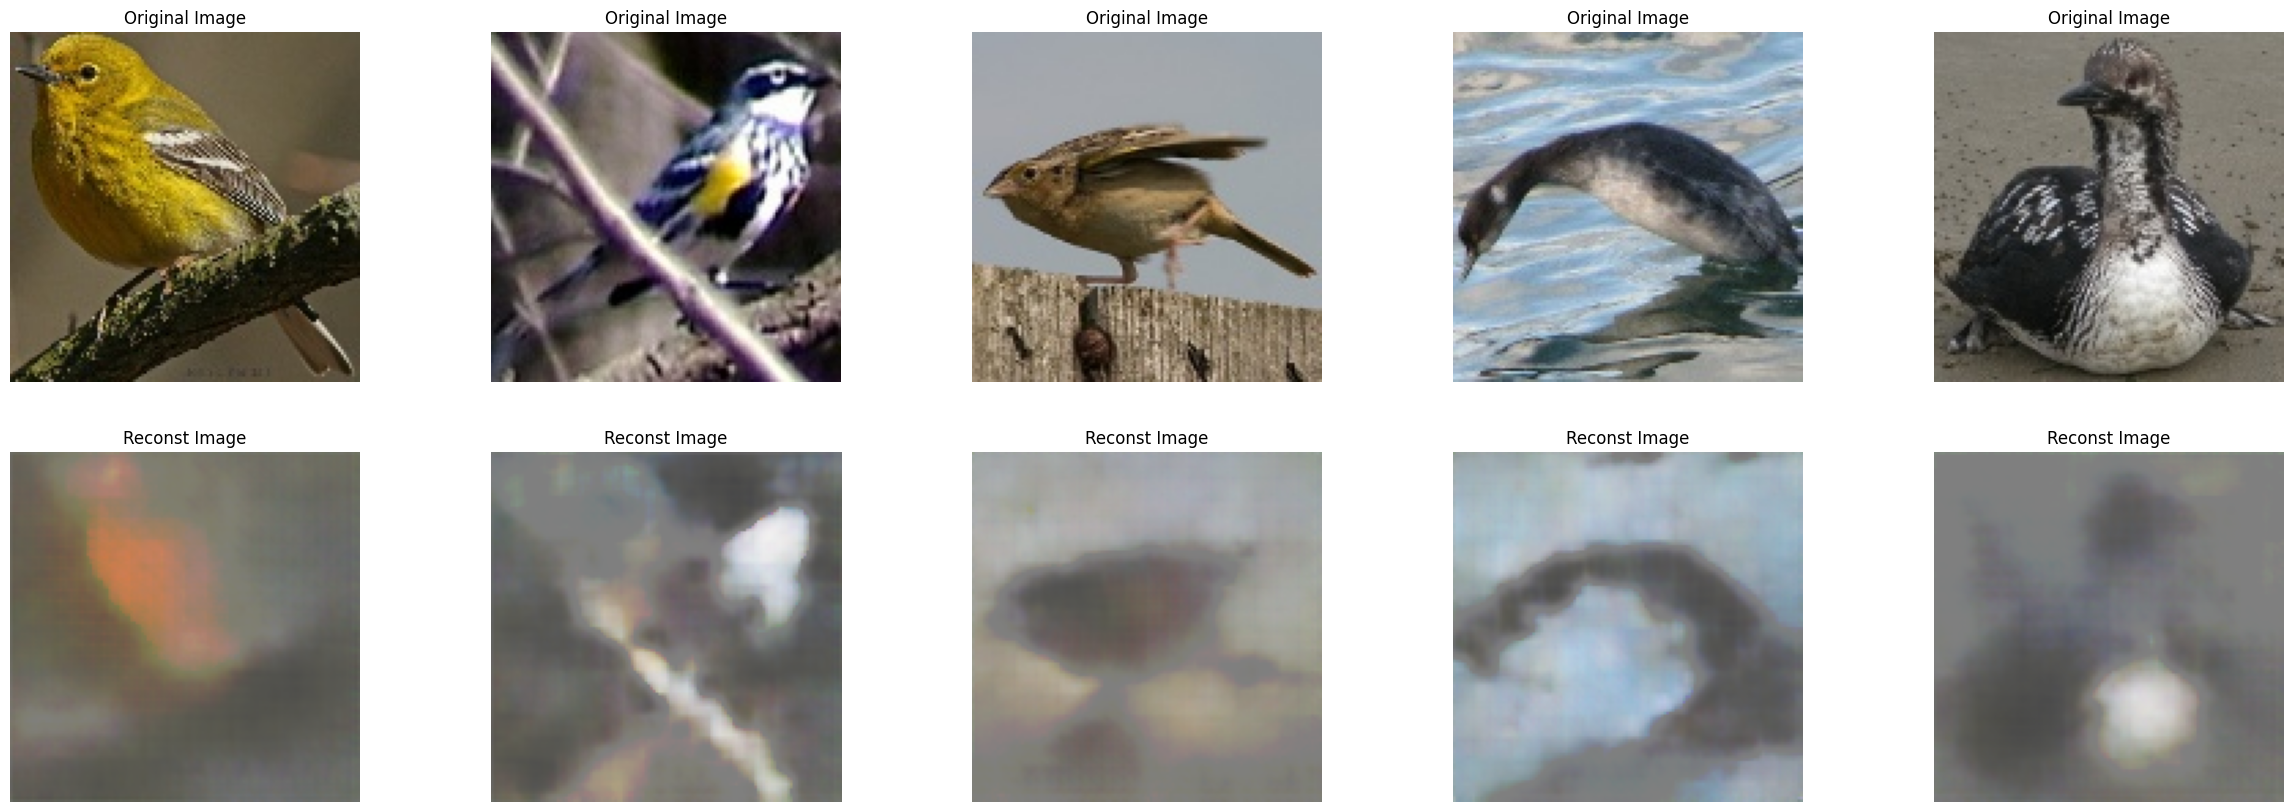

In [84]:
num_images_to_display = 5
fig, axes = plt.subplots(2, num_images_to_display, figsize=(30, 10))

assert(num_images_to_display <= LOADER_BATCH_SIZE)
with torch.no_grad():
  for image, features in train_loader:
    image = image.to(DEVICE)
    reconst, _, _, _, _, _ = model(image)

    image = image.cpu().permute(0, 2, 3, 1).numpy()
    reconst = reconst.cpu().permute(0, 2, 3, 1).numpy()

    for i in range(num_images_to_display):
        axes[0][i].imshow(image[i])
        axes[0][i].set_title("Original Image")
        axes[0][i].axis('off')
        axes[1][i].imshow(reconst[i])
        axes[1][i].set_title("Reconst Image")
        axes[1][i].axis('off')
    break

plt.show()

## Interpolation

In [6]:
train_loader = get_dataloader(options.IMG_PROCESSED_DIRPATH, options.IMGLIST_PROCESSED_FILEPATH, features_df, batch_size=1)

In [7]:
def show_(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), figsize=(25,25), squeeze=False)
    for i, ax in enumerate(axs.flatten()): 
        img = imgs[i]
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap = "gray")
        axs[0, i].axis("off")
    plt.show()

In [42]:
def compute_representations(model, train_loader):
    model.eval()

    z_distribution = list()
    latent_z = list()
    latent_mu = list()
    z_gpu = list()
    output_images = list()
    input_images = list()
    feature_vals = list()

    i = 0
    for image, features in train_loader:
        image = image.to(DEVICE)
        reconst, mu, logvar, z_tilde, z_dist, prior_dist = model(image)

        z_gpu.append(z_tilde)
        z = z_tilde.detach().cpu().numpy()
        latent_z.append(z)
        z_distribution.append(z_dist)
        latent_mu.append(mu.detach().cpu().numpy())
        output_images.append(reconst.detach().cpu().numpy())
        input_images.append(image.detach().cpu().numpy())
        feature_vals.append(features)
        
        i += 1
        if i >= 2:
            break

    return z_distribution, latent_z, latent_mu, output_images, input_images, z_gpu

z_distribution, latent_z, latent_mu, output_images, input_images, z_gpu = compute_representations(model, train_loader)


In [41]:
def linear_interpolate(code1, code2, alpha): 
    return code1 * alpha + code2 * (1 - alpha)

def make_latent_interp_animation(code_1, code_2, model, num_interps):
    model.eval()
    code_1 = torch.from_numpy(np.asarray(code_1))
    img1 = model.decode(code_1.unsqueeze(0))
    img1_ = img1.detach().cpu().numpy()

    code_2 = torch.from_numpy(np.asarray(code_2))
    img2 = model.decode(code_2.unsqueeze(0))
    img2_ = img2.detach().cpu().numpy()

    step_size = 1.0/num_interps
    
    all_imgs = []
    
    amounts = np.arange(0, 1, step_size)
    all_imgs.append(img2[0,:,:,:])
    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolate(code_1, code_2, alpha)
        interpolated_latent_code_ = torch.from_numpy(np.asarray(interpolated_latent_code))
        images = model.decode(interpolated_latent_code_.unsqueeze(0))
        #images_ = images.detach().cpu().numpy()
        interp_latent_image = images[0,:,:,:]
        all_imgs.append(interp_latent_image)

    all_imgs.append(img1[0,:,:,:])

    return all_imgs


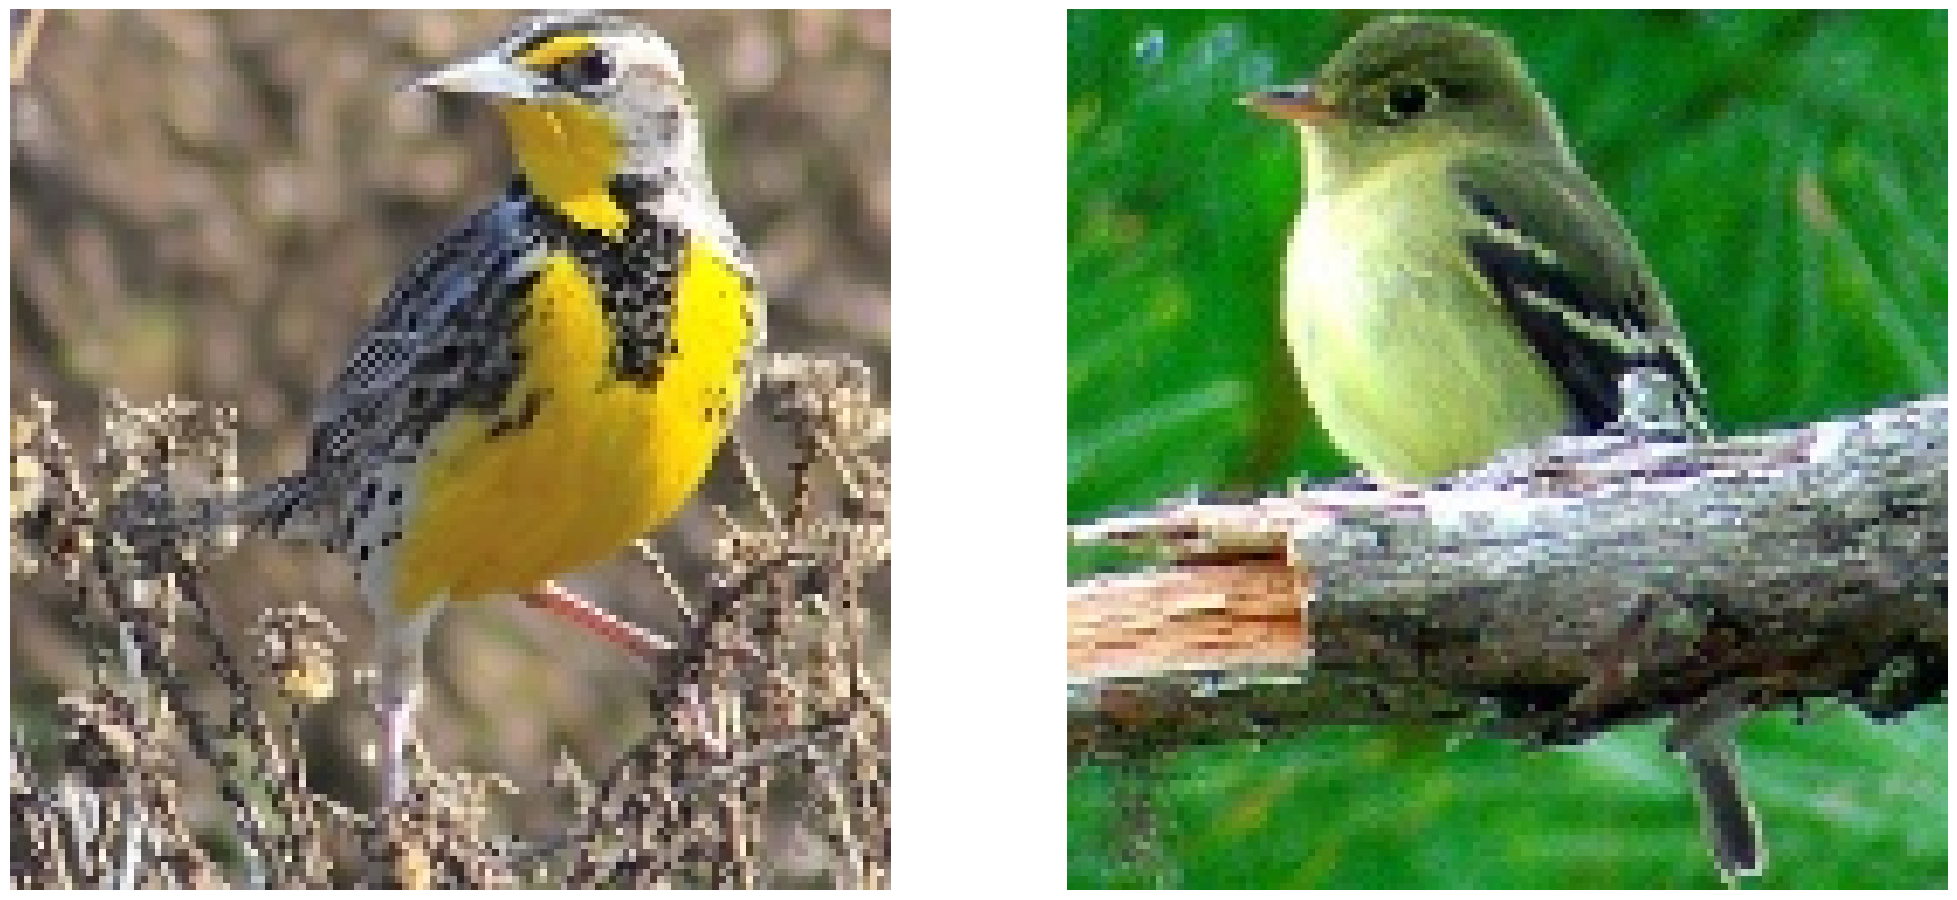

100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


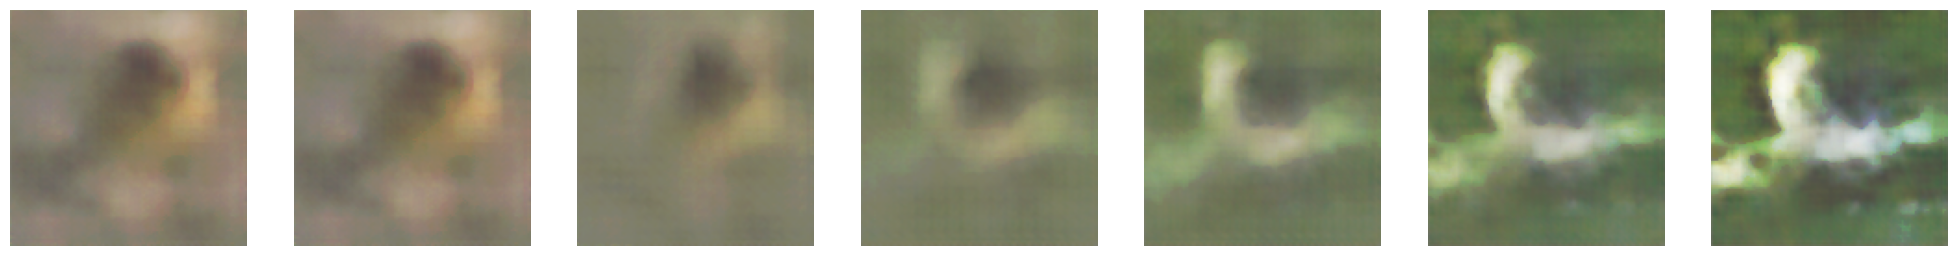

In [68]:
case1 = 0
case2 = 1
z_distribution, latent_z, latent_mu, output_images, input_images, z_gpu = compute_representations(model, train_loader)
latent_code2 = latent_z[case1][0]
latent_code1 = latent_z[case2][0]
show_([torch.tensor(input_images[case1][0]), torch.tensor(input_images[case2][0])])
interpolated_images = make_latent_interp_animation(latent_code1, latent_code2, model, num_interps = 5)
show_(interpolated_images)


In [23]:
interpolated_images == None

False

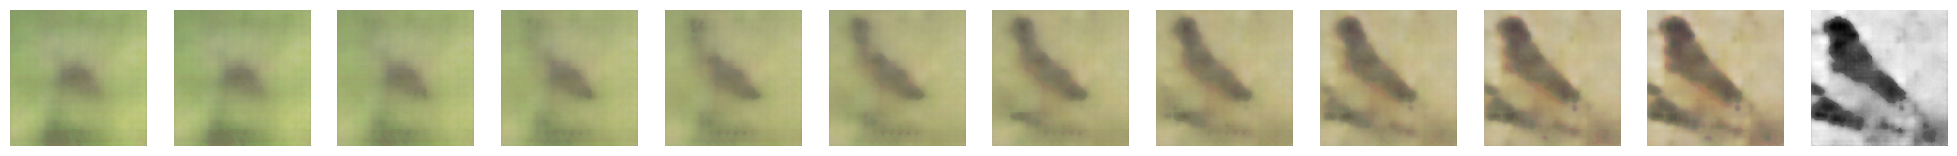